In [2]:
# Import dependencies
import pandas as pd
from sqlalchemy import create_engine
from pathlib import Path
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
# import r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from config import AWS_pass

In [3]:
# Creating connection to database 
conn = psycopg2.connect(
    host="mypostgresdb.ckmzzavm8bgu.us-east-1.rds.amazonaws.com",
    database="EV_DB",
    user="root",
    password=AWS_pass)

In [4]:
# Sample query
sql_query = """
SELECT * 
FROM clean_table
"""

In [5]:
# Create connection to AWS Database
EV_stations_df = pd.read_sql(sql_query, conn)
EV_stations_df.sample(n=10)

,id,city,province_id,province_name,city_population,median_income,unemployment_rate,city_electricity_rate,city_ev_registrations,city_ev_stations_locations,incentives_status,ev_per_province,no_certificate_perc,secondary_hs_perc,apprenticeship_per,college_cegep_perc,univ_diploma_below_bachelor_per,univ_diploma_above_bachelor_per
583,1124000887,Lanark Highlands,ON,Ontario,5338,41200,9.4,13.0,14,0,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0
1396,1124546267,Fortune,NL,Newfoundland and Labrador,1401,36800,12.5,13.8,0,0,YES,0,23.4,25.0,11.3,23.1,2.4,14.8
1373,1124622637,Elk Point,AB,Alberta,1452,44800,10.9,16.6,0,0,YES,0,16.9,27.9,9.7,19.2,3.0,23.4
1464,1124182292,Saint-Valère,QC,Quebec,1286,40800,7.2,7.3,0,0,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5
477,1124000763,Hampstead,QC,Quebec,7153,40800,7.2,7.3,0,0,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5
1397,1124001991,Faraday,ON,Ontario,1401,41200,9.4,13.0,10,0,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0
602,1124037311,Westlock,AB,Alberta,5101,44800,10.9,16.6,0,1,YES,0,16.9,27.9,9.7,19.2,3.0,23.4
187,1124001797,Wilmot,ON,Ontario,20545,41200,9.4,13.0,218,0,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0
540,1124372298,Bay Roberts,NL,Newfoundland and Labrador,6012,36800,12.5,13.8,0,0,YES,0,23.4,25.0,11.3,23.1,2.4,14.8
66,1124400266,Newmarket,ON,Ontario,84224,41200,9.4,13.0,683,26,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0


In [6]:
# Copy original EV_stations_df DataFrame to features_df
features_df = EV_stations_df.copy()
features_df.head()

,id,city,province_id,province_name,city_population,median_income,unemployment_rate,city_electricity_rate,city_ev_registrations,city_ev_stations_locations,incentives_status,ev_per_province,no_certificate_perc,secondary_hs_perc,apprenticeship_per,college_cegep_perc,univ_diploma_below_bachelor_per,univ_diploma_above_bachelor_per
0,1124279679,Toronto,ON,Ontario,5429524,41200,9.4,13.0,54739,294,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0
1,1124586170,Montreal,QC,Quebec,3519595,40800,7.2,7.3,61203,709,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5
2,1124825478,Vancouver,BC,British Columbia,2264823,40800,7.4,12.6,68894,218,YES,148116,15.5,29.4,8.8,18.1,3.6,24.6
3,1124690423,Calgary,AB,Alberta,1239220,44800,10.9,16.6,0,93,YES,0,16.9,27.9,9.7,19.2,3.0,23.4
4,1124290735,Edmonton,AB,Alberta,1062643,44800,10.9,16.6,0,70,YES,0,16.9,27.9,9.7,19.2,3.0,23.4


In [7]:
# Drop the columns identifying each city: id, city, province_id, province_name
features_df = features_df.drop(columns=["id", "province_id", "city", "province_name"])

features_df.head(10)

,city_population,median_income,unemployment_rate,city_electricity_rate,city_ev_registrations,city_ev_stations_locations,incentives_status,ev_per_province,no_certificate_perc,secondary_hs_perc,apprenticeship_per,college_cegep_perc,univ_diploma_below_bachelor_per,univ_diploma_above_bachelor_per
0,5429524,41200,9.4,13.0,54739,294,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0
1,3519595,40800,7.2,7.3,61203,709,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5
2,2264823,40800,7.4,12.6,68894,218,YES,148116,15.5,29.4,8.8,18.1,3.6,24.6
3,1239220,44800,10.9,16.6,0,93,YES,0,16.9,27.9,9.7,19.2,3.0,23.4
4,1062643,44800,10.9,16.6,0,70,YES,0,16.9,27.9,9.7,19.2,3.0,23.4
5,989567,41200,9.4,13.0,6091,159,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0
6,721599,41200,9.4,13.0,4863,171,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0
7,705244,39200,7.6,9.9,0,45,YES,3290,22.0,29.6,7.7,17.7,2.9,20.1
8,705103,40800,7.2,7.3,0,149,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5
9,693645,41200,9.4,13.0,7616,43,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0


In [8]:
# Save categorical variable column incentives_status to variable for encoding
incentives = features_df.dtypes[features_df.dtypes == "object"].index.tolist()

In [9]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable column incentive_status
encode_df = pd.DataFrame(enc.fit_transform(features_df[incentives]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(incentives)

In [10]:
# Merge the incentive_status_YES column back to original dataframe and drop the original incentives_status column
features_df = features_df.merge(encode_df, left_index=True, right_index=True)
features_df = features_df.drop(columns=["incentives_status", "incentives_status_NO"], axis=1)

In [11]:
# Split preprocessed data and define target variable and features
y = features_df["city_ev_stations_locations"]
X = features_df.drop(["city_ev_stations_locations"],axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=78)

In [12]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Use RandomForestRegressor model

In [13]:
# Define the model
regr = RandomForestRegressor()

# Fit the model
regr_model = regr.fit(X_train_scaled, y_train)

# Make predictions
y_pred = regr_model.predict(X_test_scaled)
print(y_pred.shape)

(426,)


In [14]:
# predict the accuracy score
score = r2_score(y_test, y_pred)
print('r2 score is: ', score)
print('mean squared error is : ', mean_squared_error(y_test, y_pred))
print('root mean squared error is : ', np.sqrt(mean_squared_error(y_test, y_pred)))

r2 score is:  0.7250301301947837
mean squared error is :  14.220754196195696
root mean squared error is :  3.7710415267132364


In [15]:
print(y_pred)

[2.71000000e+00 1.56000000e+00 1.33000000e+00 1.89333333e-01
 4.20000000e-01 4.89000000e+00 7.20000000e-01 4.39000000e+00
 3.40000000e+00 6.50000000e-01 6.30000000e-01 5.20000000e-01
 0.00000000e+00 2.70600000e+01 7.10000000e-01 2.38000000e+00
 5.90000000e-01 2.33000000e+00 1.87000000e+00 2.50000000e-01
 4.08000000e+00 3.01000000e+00 1.41000000e+00 7.10000000e-01
 1.15000000e+00 7.54000000e+00 2.00000000e-02 7.10000000e-01
 0.00000000e+00 4.04000000e+00 1.33600000e+01 7.03571429e-02
 1.41000000e+00 2.20000000e-01 3.14000000e+00 8.00000000e-02
 6.00000000e-02 2.11666667e-01 6.00000000e-01 7.40000000e-01
 1.81833333e-01 1.10000000e+00 0.00000000e+00 1.03000000e+00
 4.20000000e-01 8.20000000e-01 5.80000000e-01 2.80000000e-02
 1.81833333e-01 1.00000000e-01 4.80000000e-01 8.10000000e-01
 7.00000000e-02 4.64000000e+00 1.31000000e+00 2.67700000e+01
 1.02400000e+01 2.16000000e+00 3.28000000e+00 5.78000000e+00
 4.68000000e+00 6.75900000e+01 7.55000000e-01 0.00000000e+00
 7.13333333e-02 5.500000

In [16]:
# check score
regr_model.score(X_test_scaled, y_test)

0.7250301301947837

In [17]:
# Generate feature importances
feature_columns = features_df.drop(["city_ev_stations_locations"], axis=1)
feature_names = list(feature_columns.columns.values)
importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state =78, n_jobs=2)

feature_importances = pd.Series(importances.importances_mean, index=feature_names)

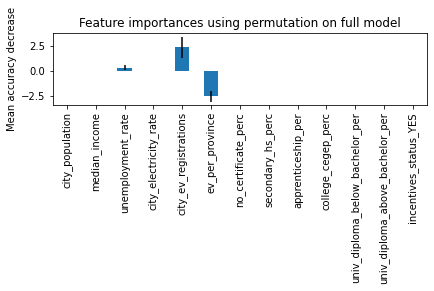

In [18]:
# Plot feature importance
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [19]:
# Save the model
import pickle

# Save the trained model
EV_station_predictions = "station_prediction_model.pkl"

with open(EV_station_predictions, 'wb') as file:
    pickle.dump(regr_model, file)

In [20]:
# Load the model
with open(EV_station_predictions, 'rb') as file:
    prediction_model = pickle.load(file)

prediction_model

RandomForestRegressor()

In [21]:
full_preds = prediction_model.predict(X_train_scaled)
print(full_preds.shape)
full_preds

(1278,)


array([0.000e+00, 6.820e+00, 2.500e-02, ..., 2.657e+01, 1.070e+00,
       3.000e-01])

In [22]:
exist_train = pd.DataFrame(y_train)
exist_train

,city_ev_stations_locations
1354,0
298,8
1660,0
49,18
623,2
...,...
310,0
105,0
40,31
470,0


In [23]:
train_predictions = exist_train
train_predictions["model_predictions"] = full_preds
train_predictions

,city_ev_stations_locations,model_predictions
1354,0,0.000
298,8,6.820
1660,0,0.025
49,18,13.530
623,2,1.850
...,...,...
310,0,0.740
105,0,2.100
40,31,26.570
470,0,1.070


In [24]:
# Merge the training predictions and the EV_stations_df
EV_train_predictions = EV_stations_df.merge(train_predictions, left_index=True, right_index=True)
EV_train_predictions = EV_train_predictions.drop(columns="city_ev_stations_locations_x", axis=1)
EV_train_predictions

,id,city,province_id,province_name,city_population,median_income,unemployment_rate,city_electricity_rate,city_ev_registrations,incentives_status,ev_per_province,no_certificate_perc,secondary_hs_perc,apprenticeship_per,college_cegep_perc,univ_diploma_below_bachelor_per,univ_diploma_above_bachelor_per,city_ev_stations_locations_y,model_predictions
0,1124279679,Toronto,ON,Ontario,5429524,41200,9.4,13.0,54739,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0,294,340.39
1,1124586170,Montreal,QC,Quebec,3519595,40800,7.2,7.3,61203,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5,709,538.29
2,1124825478,Vancouver,BC,British Columbia,2264823,40800,7.4,12.6,68894,YES,148116,15.5,29.4,8.8,18.1,3.6,24.6,218,305.52
3,1124690423,Calgary,AB,Alberta,1239220,44800,10.9,16.6,0,YES,0,16.9,27.9,9.7,19.2,3.0,23.4,93,114.63
5,1124399363,Ottawa,ON,Ontario,989567,41200,9.4,13.0,6091,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0,159,150.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,1124000091,Assiginack,ON,Ontario,1013,41200,9.4,13.0,1,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0,0,0.00
1696,1124260692,Hudson Hope,BC,British Columbia,1012,40800,7.4,12.6,0,YES,148116,15.5,29.4,8.8,18.1,3.6,24.6,0,0.07
1699,1124105436,Durham-Sud,QC,Quebec,1008,40800,7.2,7.3,0,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5,0,0.02
1701,1124001339,Nipawin No. 487,SK,Saskatchewan,1004,42400,7.0,18.1,0,YES,2222,20.7,30.5,10.4,17.1,3.3,18.0,0,0.36


In [25]:
# Save prediction DataFrame to csv file
# Create filepath
filepath = Path('..\Datasets\Training_Station_Predictions.csv')

# Save the file
EV_train_predictions.to_csv(filepath)

In [26]:
existing = pd.DataFrame(y_test)
existing

,city_ev_stations_locations
220,5
504,3
488,0
1262,5
1135,0
...,...
693,7
1109,0
1189,0
990,0


In [27]:
predictions_df = existing
predictions_df["model_predictions"] = y_pred
predictions_df

,city_ev_stations_locations,model_predictions
220,5,2.710000
504,3,1.560000
488,0,1.330000
1262,5,0.189333
1135,0,0.420000
...,...,...
693,7,0.570000
1109,0,0.000000
1189,0,0.000000
990,0,0.040000


In [28]:
# Merge the training predictions and the EV_stations_df
EV_test_predictions = EV_stations_df.merge(predictions_df, left_index=True, right_index=True)
EV_test_predictions = EV_test_predictions.drop(columns="city_ev_stations_locations_x", axis=1)
EV_test_predictions

,id,city,province_id,province_name,city_population,median_income,unemployment_rate,city_electricity_rate,city_ev_registrations,incentives_status,ev_per_province,no_certificate_perc,secondary_hs_perc,apprenticeship_per,college_cegep_perc,univ_diploma_below_bachelor_per,univ_diploma_above_bachelor_per,city_ev_stations_locations_y,model_predictions
4,1124290735,Edmonton,AB,Alberta,1062643,44800,10.9,16.6,0,YES,0,16.9,27.9,9.7,19.2,3.0,23.4,70,116.73
12,1124158530,Kitchener,ON,Ontario,470015,41200,9.4,13.0,1231,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0,38,57.22
19,1124704011,Niagara Falls,ON,Ontario,308596,41200,9.4,13.0,269,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0,18,26.77
22,1124261024,Windsor,ON,Ontario,276165,41200,9.4,13.0,1601,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0,33,30.74
25,1124817304,Burnaby,BC,British Columbia,232755,40800,7.4,12.6,4454,YES,148116,15.5,29.4,8.8,18.1,3.6,24.6,71,67.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1124001084,Brébeuf,QC,Quebec,1012,40800,7.2,7.3,0,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5,0,0.02
1697,1124000733,Prince,ON,Ontario,1010,41200,9.4,13.0,0,NO,144128,17.5,27.4,6.0,20.8,2.2,26.0,0,0.00
1698,1124218916,Baie-du-Febvre,QC,Quebec,1010,40800,7.2,7.3,0,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5,1,0.02
1700,1124850489,Melbourne,QC,Quebec,1004,40800,7.2,7.3,0,YES,252020,19.9,21.5,16.9,17.6,3.6,20.5,1,0.02


In [29]:
# Save prediction DataFrame to csv file
# Create filepath
filepath = Path('..\Datasets\Testing_Station_Predictions.csv')

# Save the file
EV_test_predictions.to_csv(filepath)